### Imports

In [1]:
# Remove Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# General
import numpy as np

# Data Management
import pandas as pd
from sklearn.model_selection import train_test_split

# Machine Learning
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Evaluation
from sklearn.metrics import precision_score

# Reporting
import matplotlib.pyplot as plt

### Import Preprocessed Data

In [2]:
df = pd.read_csv("data/BTC-USD.csv")
df.set_index("Date", inplace=True)
df.head(3)

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-31,0.000878,0.053054,0.001615,970.403015,1.103895,0.054348,0.055442,-0.029463,60.205366,1.192634,...,885.613522,1,0.011408,0.057910,0.000964,0.003887,1.003974,-0.002272,0.004646,0.991144
2017-02-01,0.054272,0.017587,0.054056,989.023010,-0.087932,0.019188,0.018926,-0.009863,63.109498,1.048237,...,895.673808,2,0.007132,0.057381,0.054348,0.055442,1.192634,0.000964,0.003887,1.003974
2017-02-02,0.019630,0.024675,0.012855,1011.799988,-0.028572,0.023030,0.030816,0.012600,66.345006,1.051268,...,905.529332,3,0.008542,0.057675,0.019188,0.018926,1.048237,0.054348,0.055442,1.192634


### Add Prediction Target

In [3]:
# Specify Target
df.loc[df["Range"].shift(-1) > df["Avg_Range"], "TARGET"] = 1
df.loc[df["Range"].shift(-1) <= df["Avg_Range"], "TARGET"] = 0

In [4]:
# Check for NaNs
nan_location = np.where(np.isnan(df))
nan_location

(array([2095]), array([21]))

In [5]:
# Fill NA
df["TARGET"].fillna(0, inplace=True)
df.tail()

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2,TARGET
Date,,,,,,,,,,,,,,,,,,,,,
2022-10-23,0.001844,0.020708,-0.000421,19567.007812,0.374080,0.018680,0.027319,21.849943,52.470317,1.125770,...,6,0.016827,0.027681,0.001863,0.006054,1.013388,0.006231,0.024848,1.045301,0.0
2022-10-24,0.018744,-0.002928,0.004294,19345.572266,0.364839,-0.011317,0.019931,21.590646,48.902095,0.931995,...,0,0.024198,0.027553,0.018680,0.027319,1.125770,0.001863,0.006054,1.013388,1.0
2022-10-25,-0.011386,0.038761,0.002870,20095.857422,0.581390,0.038783,0.056432,22.462557,59.060854,1.207737,...,1,0.070106,0.028653,-0.011317,0.019931,0.931995,0.018680,0.027319,1.125770,1.0
2022-10-26,0.038629,0.028981,0.042295,20770.441406,0.233125,0.033568,0.042937,23.252913,65.669495,1.111895,...,2,0.081305,0.029099,0.038783,0.056432,1.207737,-0.011317,0.019931,0.931995,1.0
2022-10-27,0.033872,-0.004016,0.008929,20285.835938,-0.157410,-0.023331,0.029556,22.694091,58.378851,0.888980,...,3,0.063807,0.027577,0.033568,0.042937,1.111895,0.038783,0.056432,1.207737,0.0


### Train Test Split

In [6]:
# Remove unwanted columns
df_tts = df.copy()
df_tts.drop(columns=["Close", "Bench_C_Rets", "Open", "High", "Low"], inplace=True)

In [7]:
# Split into Learning (X) and Target (y) Data
X = df_tts.iloc[:, : -1]
y = df_tts.iloc[:, -1]

In [8]:
# Perform Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)

Shape of X_train:  (1676, 16)
Shape of y_train:  (1676,)


### Build Initial Model

In [9]:
# Select type of model to optimize for
is_binary = True
is_optimise_for_precision = True

In [10]:
# Determine Objective and Eval Metrics
if is_binary:
    objective = "binary:logistic"
    eval_metric = "logloss"
    eval_metric_list = ["error", "logloss", eval_metric]
else:
    objective = "multi:softmax"
    eval_metric = "mlogloss"
    eval_metric_list = ["merror", "mlogloss", eval_metric]

In [11]:
# Refine Eval Metric
if is_binary and is_optimise_for_precision:
    eval_metric = "aucpr"
    scoring = "precision"
elif is_binary and not is_optimise_for_precision:
    eval_metric = "auc"
    scoring = "f1"
else:
    scoring = "accuracy"

In [12]:
# Build First Classifier Model 0
classifier_0 = XGBClassifier(
    objective=objective,
    booster="gbtree",
    eval_metric=eval_metric,
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
)

### Find Hyperparameters

In [13]:
# Provide Gris for Hyperparams
param_grid = {
    "gamma": [0, 0.1, 0.2, 0.5, 1, 1.5, 2, 3, 6, 12, 20],
    "learning_rate": [0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8],
    "max_depth": [1, 2, 3, 4, 5, 6, 8, 12],
    "n_estimators": [25, 50, 65, 80, 100, 115, 200]
}

In [14]:
# Perform Random Search for Best Hyper params
grid_search = RandomizedSearchCV(estimator=classifier_0, param_distributions=param_grid, scoring=scoring)
best_model = grid_search.fit(X_train, y_train)
hyperparams = best_model.best_params_
ne = hyperparams["n_estimators"]
lr = hyperparams["learning_rate"]
md = hyperparams["max_depth"]
gm = hyperparams["gamma"]
print("Recommended Params >>", f"ne: {ne},", f"lr: {lr}", f"md: {md}", f"gm: {gm}")

Recommended Params >> ne: 80, lr: 0.03 md: 12 gm: 12


### Train Model

In [15]:
# Build Classification Model 1
classifier_1 = XGBClassifier(
    objective=objective,
    booster="gbtree",
    eval_metric=eval_metric,
    n_estimators=ne,
    learning_rate=lr,
    max_depth=md,
    gamma=gm,
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
)

In [16]:
# Fit Model
eval_set = [(X_train, y_train)]
classifier_1.fit(
    X_train,
    y_train,
    eval_metric=eval_metric_list,
    eval_set=eval_set,
    verbose=False
)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='aucpr', gamma=12, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.03, max_delta_step=0,
              max_depth=12, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=80, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

### Performance Evaluation (Quick Overview)

In [17]:
# Get predictions for training data
train_yhat = classifier_1.predict(X_train)
print("Training Preds: \n", train_yhat[:5])

Training Preds: 
 [0 0 0 0 1]


In [18]:
# Set K-Fold Cross Validation Levels
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

In [19]:
# Training Results
train_results = cross_val_score(classifier_1, X_train, y_train, scoring=scoring, cv=cv, n_jobs=1)

In [20]:
# Brief Review of Training Results
print("Average Accuracy K-Fold: ", round(train_results.mean(), 2))
print("Std Deviation K-Fold: ", round(train_results.std(), 2))
print("Precision Score 0: ", round(precision_score(y_train, train_yhat, average=None)[0], 3))
print("Precision Score 1: ", round(precision_score(y_train, train_yhat, average=None)[1], 3))
print("")
print("Just for reference. Right now, we are only focussed on getting some initial features.")
print("If the results look too good to be true, they probably are.")

Average Accuracy K-Fold:  0.66
Std Deviation K-Fold:  0.05
Precision Score 0:  0.724
Precision Score 1:  0.769

Just for reference. Right now, we are only focussed on getting some initial features.
If the results look too good to be true, they probably are.


### Feature Selection

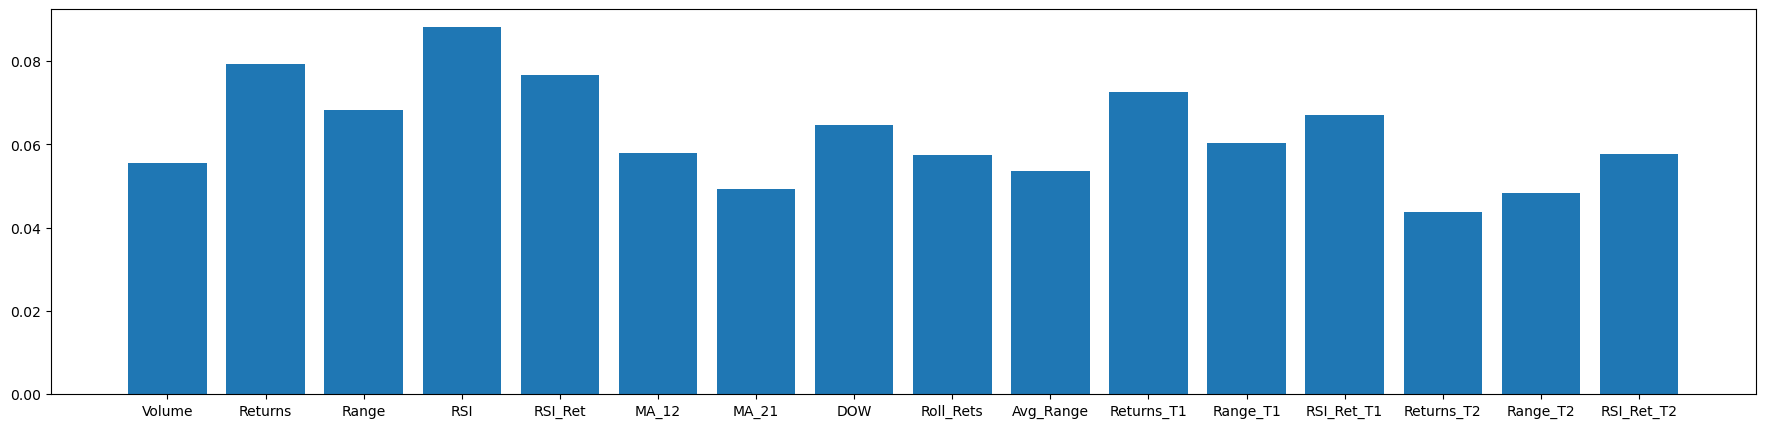

In [21]:
# Plot Feature Importances
fig = plt.figure(figsize=(22, 5))
importance_labels = X.columns
importance_features = classifier_1.feature_importances_
plt.bar(importance_labels, importance_features)
plt.show()

In [22]:
# Select Best Features
mean_feature_importance = importance_features.mean()
i = 0
recommended_feature_labels = []
recommended_feature_score = []
for fi in importance_features:
    if fi > mean_feature_importance:
        recommended_feature_labels.append(importance_labels[i])
        recommended_feature_score.append(fi)
    i += 1

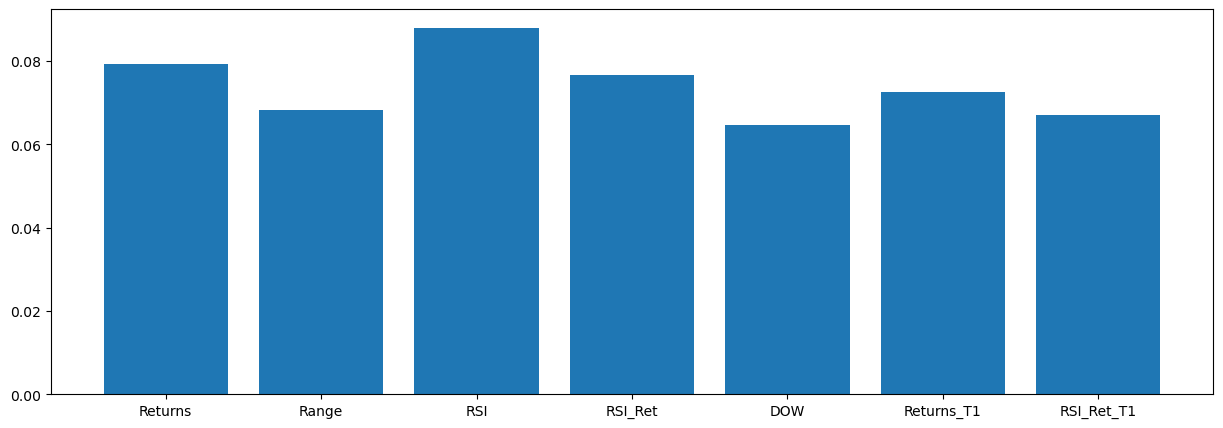

In [23]:
# Plot Recommended Features
fig = plt.figure(figsize=(15, 5))
plt.bar(recommended_feature_labels, recommended_feature_score)
plt.show()